In [1]:
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction import FeatureHasher
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import (
    log_loss,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split

## Load Dataset

In [2]:
df_impression_log = pd.read_csv("../data/train/impression_log/impression_log.csv")
df_view_log = pd.read_csv("../data/train/view_log/view_log.csv")
df_item = pd.read_csv("../data/train/mst_item/mst_item.csv")

In [3]:
df_impression_log.head()

,impression_id,logged_at,user_id,app_code,os_version,is_4G,is_click
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0


In [4]:
df_view_log.head()

,logged_at,device_type,session_id,user_id,item_id
0,2018-10-15 08:58:00,android,112333,4557,32970
1,2018-10-15 08:58:00,android,503590,74788,7640
2,2018-10-15 08:58:00,android,573960,23628,128855
3,2018-10-15 08:58:00,android,121691,2430,12774
4,2018-10-15 08:58:00,android,218564,19227,28296


In [5]:
df_item.head()

,item_id,item_price,category_1,category_2,category_3,product_type
0,26880,4602,11,35,20,3040
1,54939,3513,12,57,85,6822
2,40383,825,17,8,279,1619
3,8777,2355,13,58,189,5264
4,113705,1267,17,39,151,10239


In [6]:
print(f"df_impression shape: {df_impression_log.shape}")
print(f"df_view_log shape: {df_view_log.shape}")
print(f"df_item shape: {df_item.shape}")

df_impression shape: (237609, 7)
df_view_log shape: (3118622, 5)
df_item shape: (132761, 6)


In [7]:
df_impression_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237609 entries, 0 to 237608
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   impression_id  237609 non-null  object
 1   logged_at      237609 non-null  object
 2   user_id        237609 non-null  int64 
 3   app_code       237609 non-null  int64 
 4   os_version     237609 non-null  object
 5   is_4G          237609 non-null  int64 
 6   is_click       237609 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 12.7+ MB


In [8]:
df_item.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132761 entries, 0 to 132760
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   item_id       132761 non-null  int64
 1   item_price    132761 non-null  int64
 2   category_1    132761 non-null  int64
 3   category_2    132761 non-null  int64
 4   category_3    132761 non-null  int64
 5   product_type  132761 non-null  int64
dtypes: int64(6)
memory usage: 6.1 MB


In [9]:
df_view_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3118622 entries, 0 to 3118621
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   logged_at    object
 1   device_type  object
 2   session_id   int64 
 3   user_id      int64 
 4   item_id      int64 
dtypes: int64(3), object(2)
memory usage: 119.0+ MB


## Preprocess Dataset

In [10]:
# preprocess code reference: https://www.kaggle.com/code/annatrofy/context-ad-clicks-machine-learning-algorithms
LOOKBACK_DAYS = 7

df_impression_log["logged_at"] = pd.to_datetime(df_impression_log["logged_at"])
df_view_log["logged_at"] = pd.to_datetime(df_view_log["logged_at"])

In [11]:
LOOKBACK_DAYS = 7

def get_impression_history_feature(df_impression_log: pd.DataFrame, lookback_days: int = LOOKBACK_DAYS) -> pd.DataFrame:
    """
    ユーザーごとのloockback_days日以内の広告表示回数を追加する。
    """
    df_impression_history = df_impression_log.merge(df_impression_log, how="left", on="user_id",
                                                    suffixes=("", "_previous"))

    df_impression_history["days_between_impressions"] = (
            df_impression_history["logged_at"] - df_impression_history["logged_at_previous"]
    ).dt.days

    df_impression_history = df_impression_history.query(
        f"(logged_at_previous < logged_at) and (days_between_impressions <= {lookback_days})"
    )

    df_impression_history_feature = (
        df_impression_history.groupby("impression_id")["impression_id_previous"]
        .count()
        .reset_index(name="previous_impression_count")
    )
    return df_impression_history_feature

In [12]:
def get_view_history_feature(
    df_impression_log: pd.DataFrame,
    df_view_log: pd.DataFrame,
    lookback_days: int = LOOKBACK_DAYS,
) -> pd.DataFrame:
    df_view_log_drop_duplicated = df_view_log.drop_duplicates(subset=["user_id", "logged_at"], keep="last")
    df_view_history = df_impression_log.merge(
        df_view_log_drop_duplicated,
        how="left",
        on="user_id",
        suffixes=("_impression", "_view"),
    )

    df_view_history["days_between_impression_and_session"] = (
            df_view_history["logged_at_impression"] - df_view_history["logged_at_view"]
    ).dt.days

    df_view_history = df_view_history.query(
        f"(logged_at_view < logged_at_impression) and (days_between_impression_and_session <= {lookback_days})"
    )

    df_view_history_features = (
        df_view_history.groupby(
            [
                "impression_id",
            ]
        )
        .agg(
            previous_view_count=("logged_at_view", "count"),
            item_id=("item_id", "last"),
            device_type=("device_type", "last"),
        )
        .reset_index()
    )
    return df_view_history_features

In [13]:
def get_impression_time_feature(df_impression_log: pd.DataFrame) -> pd.DataFrame:
    df_impression_time_feature = pd.DataFrame(
        {
            "impression_id": df_impression_log["impression_id"],
            "impression_hour": df_impression_log["logged_at"].dt.hour,
            "impression_day": df_impression_log["logged_at"].dt.day,
            "impression_weekday": df_impression_log["logged_at"].dt.weekday,
        }
    )
    return df_impression_time_feature

In [14]:
df_impression_history_feature = get_impression_history_feature(df_impression_log)
df_view_history_feature = get_view_history_feature(df_impression_log, df_view_log)
df_impression_time_feature = get_impression_time_feature(df_impression_log)

In [15]:
df_train = df_impression_log.merge(df_impression_history_feature, how="left", on="impression_id")
df_train = df_train.merge(df_view_history_feature, how="left", on="impression_id")
df_train = df_train.merge(df_impression_time_feature, how="left", on="impression_id")
df_train = df_train.merge(df_item, how="left", on="item_id")

In [16]:
df_train["previous_impression_count"] = df_train["previous_impression_count"].fillna(0)
df_train["previous_view_count"] = df_train["previous_view_count"].fillna(-1)
df_train["impression_hour"] = df_train["impression_hour"].fillna(-1)
df_train["impression_day"] = df_train["impression_day"].fillna(-1)
df_train["impression_weekday"] = df_train["impression_weekday"].fillna(-1)
df_train["item_id"] = df_train["item_id"].fillna(-1)
df_train["device_type"] = df_train["device_type"].fillna("null")
df_train["item_price"] = df_train["item_price"].fillna(-1)
df_train["category_1"] = df_train["category_1"].fillna(-1)
df_train["category_2"] = df_train["category_2"].fillna(-1)
df_train["category_3"] = df_train["category_3"].fillna(-1)
df_train["product_type"] = df_train["product_type"].fillna(-1)

In [17]:
df_train["previous_impression_count"] = df_train["previous_impression_count"].astype("int")
df_train["previous_view_count"] = df_train["previous_view_count"].astype("int")
df_train["impression_hour"] = df_train["impression_hour"].astype("int")
df_train["impression_day"] = df_train["impression_day"].astype("int")
df_train["impression_weekday"] = df_train["impression_weekday"].astype("int")
df_train["item_id"] = df_train["item_id"].astype("int")
df_train["category_1"] = df_train["category_1"].astype("int")
df_train["category_2"] = df_train["category_2"].astype("int")
df_train["category_3"] = df_train["category_3"].astype("int")
df_train["product_type"] = df_train["product_type"].astype("int")

In [18]:
df_train

,impression_id,logged_at,user_id,app_code,os_version,is_4G,is_click,previous_impression_count,previous_view_count,item_id,device_type,impression_hour,impression_day,impression_weekday,item_price,category_1,category_2,category_3,product_type
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,0,-1,-1,null,0,15,3,-1.0,-1,-1,-1,-1
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,0,-1,-1,null,0,15,3,-1.0,-1,-1,-1,-1
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0,0,-1,-1,null,0,15,3,-1.0,-1,-1,-1,-1
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0,0,9,104035,android,0,15,3,819.0,8,21,139,2944
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0,0,7,4069,android,0,15,3,4556.0,7,24,100,9215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237604,880e88bf5c86c1b11a2ac7072ebfb932,2018-12-13 07:40:00,17758,207,latest,1,0,1,6,95491,android,7,13,3,6400.0,14,61,132,9842
237605,3e6bd8cace08e2102dffef3c86d7d793,2018-12-13 07:41:00,26845,207,latest,0,0,0,1,127045,android,7,13,3,21696.0,1,7,308,4986
237606,8e58582b20ebfacb84fc338bac7cd5ae,2018-12-13 07:42:00,69412,289,old,0,0,0,-1,-1,null,7,13,3,-1.0,-1,-1,-1,-1
237607,9ccc5e0a6dc7a2f5224890a22defbd00,2018-12-13 07:43:00,19918,385,old,0,1,6,15,4337,android,7,13,3,1280.0,1,12,301,3805


In [19]:
feature_names = [
    "user_id",
    "app_code",
    "os_version",
    "is_4G",
    "previous_impression_count",
    "previous_view_count",
    "impression_hour",
    "impression_day",
    "impression_weekday",
    "item_id",
    "device_type",
    "item_price",
    "category_1",
    "category_2",
    "category_3",
    "product_type",
]

target = "is_click"

In [20]:
# Sort by impression time to split data based on the impression time
df_train = df_train.sort_values(by="logged_at")

df_train, df_test = train_test_split(df_train, test_size=0.2, random_state=42, shuffle=False)
df_train, df_valid = train_test_split(df_train, test_size=0.1, random_state=42, shuffle=False)

In [21]:
def preprocess(df: pd.DataFrame, hash_size: int = 2 ** 18) -> np.ndarray:
    feature_hasher = FeatureHasher(n_features=hash_size, input_type="string")
    hashed_feature = feature_hasher.fit_transform(np.asanyarray(df.astype(str)))

    return hashed_feature

In [22]:
X_train_preprocessed = preprocess(df_train[feature_names])
y_train = df_train[target]

X_valid_preprocessed = preprocess(df_valid[feature_names])
y_valid = df_valid[target]

X_test_preprocessed = preprocess(df_test[feature_names])
y_test = df_test[target]

## Hyperparameter Tuning

In [23]:
def optuna_search(X_train, y_train, X_valid, y_valid) -> tuple[float, float]:
    def objective(trial: optuna.trial._trial.Trial) -> float:
        max_alpha = 0.0001
        alpha = trial.suggest_float("alpha", 0, max_alpha)
        model = SGDClassifier(loss="log_loss", penalty="l2", random_state=42, alpha=alpha)

        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_valid)[:, 1]
        score = log_loss(y_true=y_valid, y_pred=y_pred)

        return float(score)

    print("Started Hyper Parameter (alpha) tuning.")
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=10)
    best_alpha = study.best_params["alpha"]
    best_score = study.best_value
    return best_alpha, best_score


best_alpha, score = optuna_search(X_train_preprocessed, y_train, X_valid_preprocessed, y_valid)

print(f"Best alpha: {best_alpha}, score: {score}")

[I 2025-09-14 12:54:37,615] A new study created in memory with name: no-name-467c634c-2578-4efc-b9b4-a5a13efbd752


Started Hyper Parameter (alpha) tuning.


[I 2025-09-14 12:54:38,067] Trial 0 finished with value: 0.17484200040497827 and parameters: {'alpha': 8.388098991541708e-05}. Best is trial 0 with value: 0.17484200040497827.
[I 2025-09-14 12:54:38,766] Trial 1 finished with value: 0.18238049349929636 and parameters: {'alpha': 2.355313221491565e-05}. Best is trial 0 with value: 0.17484200040497827.
[I 2025-09-14 12:54:39,226] Trial 2 finished with value: 0.17428830016451888 and parameters: {'alpha': 5.681519358759084e-05}. Best is trial 2 with value: 0.17428830016451888.
[I 2025-09-14 12:54:39,731] Trial 3 finished with value: 0.17430560687341526 and parameters: {'alpha': 5.573937292626841e-05}. Best is trial 2 with value: 0.17428830016451888.
[I 2025-09-14 12:54:40,298] Trial 4 finished with value: 0.1751095312131964 and parameters: {'alpha': 1.9285527233517786e-05}. Best is trial 2 with value: 0.17428830016451888.
[I 2025-09-14 12:54:40,712] Trial 5 finished with value: 0.1742050737031796 and parameters: {'alpha': 6.577406015284483e

Best alpha: 6.577406015284483e-05, score: 0.1742050737031796


## Train and Evaluate

In [24]:
best_model = SGDClassifier(loss="log_loss", penalty="l2", random_state=42, alpha=best_alpha)
best_model.fit(X_train_preprocessed, y_train)

y_pred = best_model.predict_proba(X_test_preprocessed)[:, 1]
logloss = log_loss(y_true=y_test, y_pred=y_pred)
roc_auc = roc_auc_score(y_true=y_test, y_score=y_pred)
calibration = sum(y_pred) / sum(y_test)

print(f"test logloss: {logloss}, AUC: {roc_auc}, calibration: {calibration}")

test logloss: 0.17957787062816985, AUC: 0.687375690671026, calibration: 1.0352951843486122


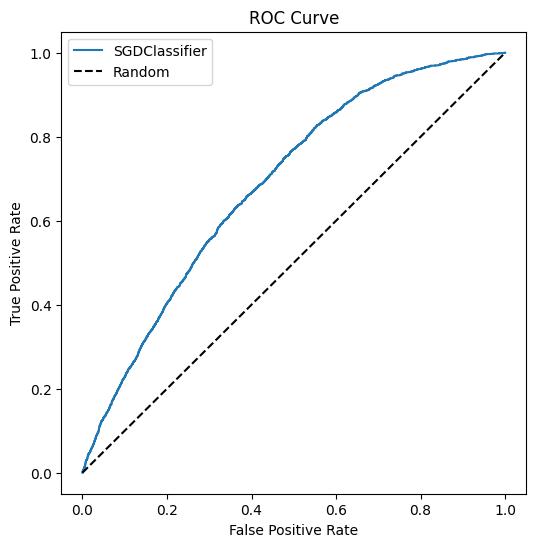

In [25]:
# ROC Curve
def roc_auc_curve(y_true, y_pred):
    [fpr, tpr, thr] = roc_curve(y_true, y_pred)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label="SGDClassifier")
    plt.plot([0, 1], [0, 1], "k--", label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()


roc_auc_curve(y_true=y_test, y_pred=y_pred)

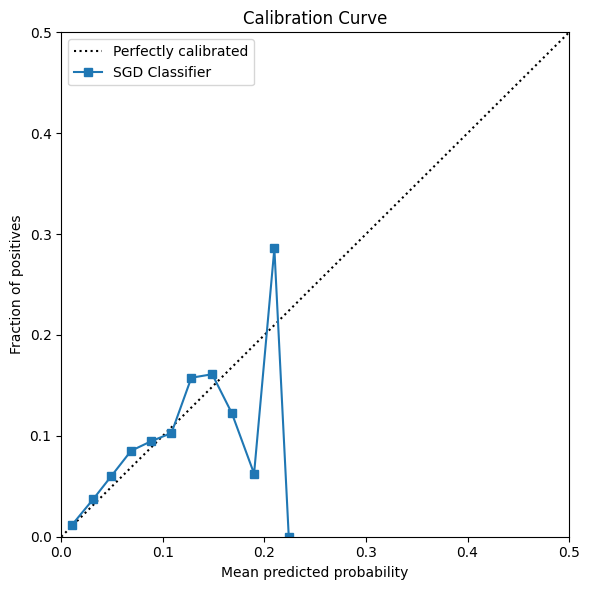

In [34]:
from sklearn.calibration import calibration_curve


def plot_calibration(y_true, y_pred, n_bins=50):
    prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=n_bins)

    plt.figure(figsize=(6, 6))

    plt.plot([0, 0.5], [0, 0.5], "k:", label="Perfectly calibrated")
    plt.plot(prob_pred, prob_true, "s-", label="SGD Classifier")

    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title("Calibration Curve")
    plt.xlim(0, 0.5)
    plt.ylim(0, 0.5)
    plt.legend(loc="best")

    plt.tight_layout()
    plt.show()


plot_calibration(y_true=y_test, y_pred=y_pred)

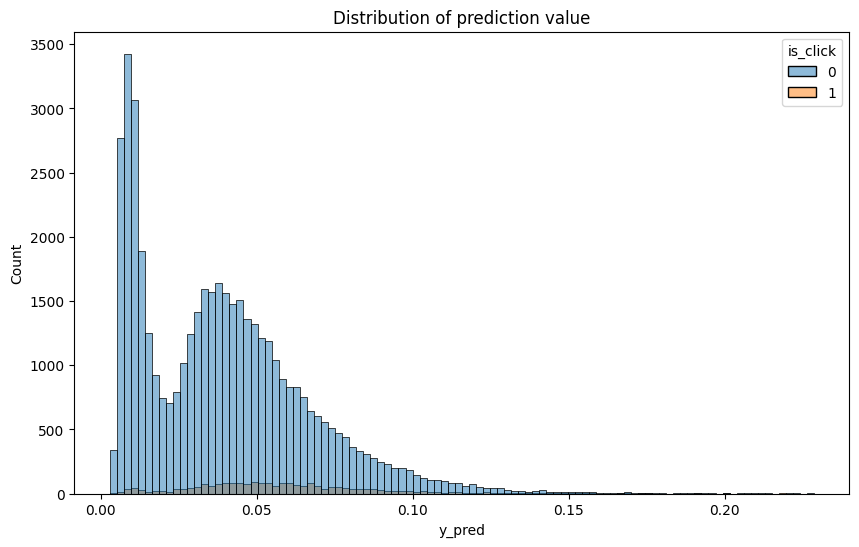

In [35]:
# Distribution of prediction value


def plot_distribution(y_true, y_pred):
    fig = plt.figure(figsize=(10, 6))
    df_hist = pd.DataFrame({"y_pred": y_pred, "is_click": y_true})
    sns.histplot(data=df_hist, x="y_pred", hue="is_click", bins=100)
    plt.title("Distribution of prediction value")
    plt.show()


plot_distribution(y_true=y_test, y_pred=y_pred)

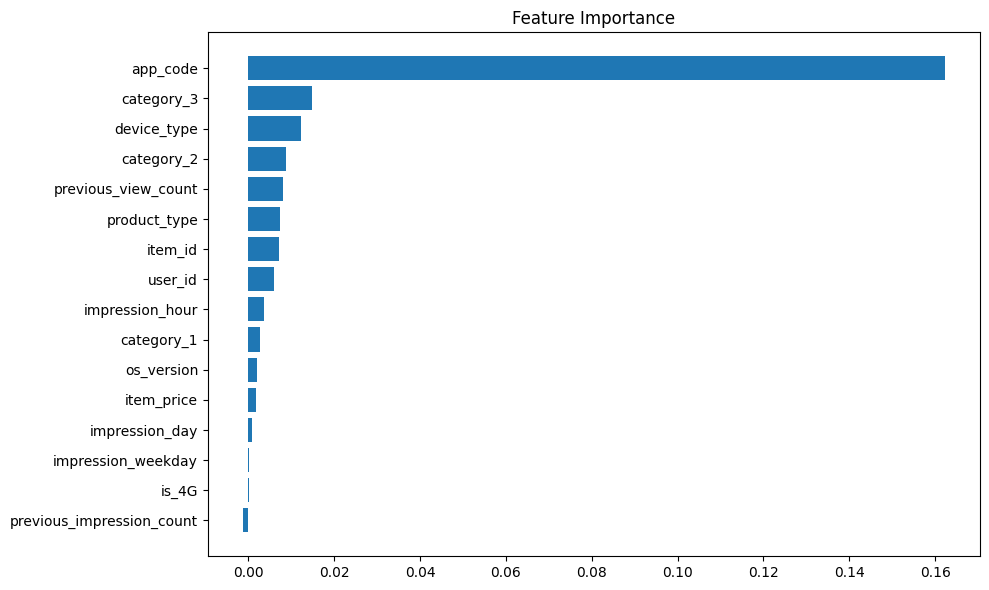

In [33]:
# Calculate permutation importance
# Code reference: https://www.kaggle.com/competitions/ieee-fraud-detection/discussion/107877


def plot_permutation_importance(
    df_test: pd.DataFrame,
    y_test: np.ndarray,
    model: SGDClassifier,
    feature_names: list[str],
) -> dict[str, float]:
    df_test_perm = df_test.copy()

    permutation_importance = {}
    y_pred = model.predict_proba(X_test_preprocessed)[:, 1]
    baseline = roc_auc_score(y_test, y_pred)
    for col in feature_names:
        value = df_test[col]
        df_test_perm[col] = np.random.permutation(df_test_perm[col].values)
        X_test_perm_preprocessed = preprocess(df_test_perm[feature_names])
        y_pred = best_model.predict_proba(X_test_perm_preprocessed)[:, 1]
        permutation_importance[col] = baseline - roc_auc_score(y_test, y_pred)
        df_test_perm[col] = value

    # DataFrameに変換してソート
    df = pd.DataFrame(list(permutation_importance.items()), columns=["Feature", "Importance"])
    df = df.sort_values("Importance")
    
    # 棒グラフの作成
    plt.figure(figsize=(10, 6))
    plt.barh(df["Feature"], df["Importance"])
    plt.title("Feature Importance")
    plt.tight_layout()
    plt.show()

plot_permutation_importance(df_test, y_test, best_model, feature_names)

## LightGBM

In [34]:
feature_names = [
    "user_id",
    "app_code",
    "os_version",
    "is_4G",
    "previous_impression_count",
    "previous_view_count",
    "impression_hour",
    "impression_day",
    "impression_weekday",
    "item_id",
    "device_type",
    "item_price",
    "category_1",
    "category_2",
    "category_3",
    "product_type",
]

category_columns = [
    "user_id",
    "app_code",
    "os_version",
    "impression_hour",
    "impression_day",
    "impression_weekday",
    "item_id",
    "device_type",
    "category_1",
    "category_2",
    "category_3",
    "product_type",
]


In [35]:
for col in category_columns:
    df_train[col] = df_train[col].astype("category")
    df_valid[col] = df_valid[col].astype("category")
    df_test[col] = df_test[col].astype("category")

In [36]:
import lightgbm as lgb

train_data = lgb.Dataset(
    df_train[feature_names],
    label=y_train,
    # feature_name=feature_names,
    categorical_feature=category_columns,
)
valid_data = lgb.Dataset(
    df_valid[feature_names],
    label=y_valid,
    # feature_name=feature_names,
    categorical_feature=category_columns,
)

In [37]:
param = {"num_leaves": 31, "objective": "binary"}
param["metric"] = "auc"
num_round = 10
model = lgb.train(param, train_data, num_round, valid_sets=[valid_data])

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 7758, number of negative: 163320
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 26294
[LightGBM] [Info] Number of data points in the train set: 171078, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.045348 -> initscore=-3.046987
[LightGBM] [Info] Start training from score -3.046987


In [38]:
df_train

,impression_id,logged_at,user_id,app_code,os_version,is_4G,is_click,previous_impression_count,previous_view_count,item_id,device_type,impression_hour,impression_day,impression_weekday,item_price,category_1,category_2,category_3,product_type
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,0,-1,-1,null,0,15,3,-1.0,-1,-1,-1,-1
19670,c81e728d9d4c2f636f067f89cc14862c,2018-11-15 00:00:00,89464,129,intermediate,0,0,0,109,30152,android,0,15,3,2227.0,4,38,62,2106
14938,eccbc87e4b5ce2fe28308fd9f2a7baf3,2018-11-15 00:00:00,58442,127,latest,0,0,0,14,73224,android,0,15,3,21696.0,1,64,263,5164
1397,a87ff679a2f3e71d9181a67b7542122c,2018-11-15 00:00:00,4238,371,latest,0,0,0,16,72955,android,0,15,3,2344.0,0,6,145,2056
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,0,-1,-1,null,0,15,3,-1.0,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147448,52e10b7ec40d26c40a4a2ac4e2037760,2018-12-04 07:08:00,21639,385,intermediate,1,0,19,13,41416,android,7,4,1,50.0,13,58,102,2455
149610,664606dc5edf7097e77bc51f669c39b3,2018-12-04 07:08:00,60582,44,intermediate,1,0,2,-1,-1,null,7,4,1,-1.0,-1,-1,-1,-1
152039,7b3754b572a2c48b3291ad2dc6e51ae7,2018-12-04 07:09:00,16881,207,latest,0,0,6,1,73972,android,7,4,1,2227.0,12,57,44,907
145464,cbcfc9330a218e70636aa232febdc7b3,2018-12-04 07:09:00,57478,207,latest,0,0,1,6,116661,android,7,4,1,832.0,11,51,181,6764


In [39]:
y_pred = model.predict(df_test[feature_names])

In [40]:
logloss = log_loss(y_true=y_test, y_pred=y_pred)
roc_auc = roc_auc_score(y_true=y_test, y_score=y_pred)

print(f"test logloss: {logloss}, AUC: {roc_auc}")

test logloss: 0.17942243978168906, AUC: 0.6974833352913389
